In [1]:
pip install kafka-python


  Using cached kafka_python-2.0.2-py2.py3-none-any.whl.metadata (7.8 kB)
Using cached kafka_python-2.0.2-py2.py3-none-any.whl (246 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from kafka import KafkaProducer
import random
import numpy as np
import struct
import time  # Agregar esta línea para importar time



In [2]:

# Configuración del productor
producer = KafkaProducer(
    bootstrap_servers='164.92.76.15:9092',
    value_serializer=lambda v: v  # Enviará bytes en lugar de JSON
)

# Lista de direcciones de viento posibles
WIND_DIRECTIONS = ['N', 'NO', 'O', 'SO', 'S', 'SE', 'E', 'NE']

# Codificación de datos a 3 bytes
def encode_message(temp, humidity, wind_direction):
    # Redondear temperatura para ajustarla a 14 bits
    temp_int = int(temp * 100)  # Asumiendo temperatura en el rango de 0 a 110.00 (se guarda sin decimales)
    humidity_int = int(humidity)  # Humedad en el rango de 0 a 100
    wind_int = WIND_DIRECTIONS.index(wind_direction)  # Convertir dirección de viento a índice (0 a 7)

    # Construir los 3 bytes
    packed_data = (temp_int << 10) | (humidity_int << 3) | wind_int
    return struct.pack('>I', packed_data)[1:]  # Mantén solo los últimos 3 bytes

# Función que genera datos simulados de los sensores
def generate_sensor_data():
    temp = np.clip(np.random.normal(25, 5), 0, 110)
    humidity = int(np.clip(np.random.normal(60, 10), 0, 100))
    wind = random.choice(WIND_DIRECTIONS)
    return temp, humidity, wind

# Función principal que envía los datos generados a Kafka
def main():
    print("Starting Weather Station Producer...")
    try:
        while True:
            # Generar datos del sensor y codificarlos en 3 bytes
            temp, humidity, wind = generate_sensor_data()
            encoded_message = encode_message(temp, humidity, wind)
            
            # Enviar el mensaje codificado (3 bytes)
            producer.send('21153', value=encoded_message)
            print(f"Sent: Encoded Message={encoded_message.hex()}, Temp={temp}°C, Humidity={humidity}%, Wind={wind}")
            
            time.sleep(random.uniform(5, 10))
            
    except KeyboardInterrupt:
        print("\nStopping producer...")
        producer.close()

if __name__ == "__main__":
    main()


Starting Weather Station Producer...
Sent: Encoded Message=222da4, Temp=21.871994082552668°C, Humidity=52%, Wind=S
Sent: Encoded Message=2a6e05, Temp=27.151527627346304°C, Humidity=64%, Wind=SE
Sent: Encoded Message=20864f, Temp=20.81891908541428°C, Humidity=73%, Wind=NE
Sent: Encoded Message=1f5186, Temp=20.047660220144955°C, Humidity=48%, Wind=E
Sent: Encoded Message=22157c, Temp=21.812575864096807°C, Humidity=47%, Wind=S
Sent: Encoded Message=3381e5, Temp=32.96945681740283°C, Humidity=60%, Wind=SE
Sent: Encoded Message=1c19f6, Temp=17.981032733657454°C, Humidity=62%, Wind=E
Sent: Encoded Message=2c09ed, Temp=28.180478146200688°C, Humidity=61%, Wind=SE
Sent: Encoded Message=302da0, Temp=30.830044518278797°C, Humidity=52%, Wind=N
Sent: Encoded Message=216609, Temp=21.378357913109124°C, Humidity=65%, Wind=NO
Sent: Encoded Message=2c9d6d, Temp=28.558594148894898°C, Humidity=45%, Wind=SE
Sent: Encoded Message=1149b3, Temp=11.067067021190402°C, Humidity=54%, Wind=SO
Sent: Encoded Message=

In [5]:
from kafka import KafkaConsumer
import struct
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque


Consumer initialized and connected to Kafka broker.
Matplotlib figure and axes configured.
Starting Weather Station Consumer...


C:\Users\jenni\AppData\Local\Temp\ipykernel_24456\1556037738.py:120: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update_plot, interval=1000, blit=True)


Attempting to consume a message...
Message consumed from Kafka.
Error: Expected 3 bytes but got 61 bytes.
Skipping message due to decoding error.
Attempting to consume a message...
Message consumed from Kafka.
Error: Expected 3 bytes but got 62 bytes.
Skipping message due to decoding error.


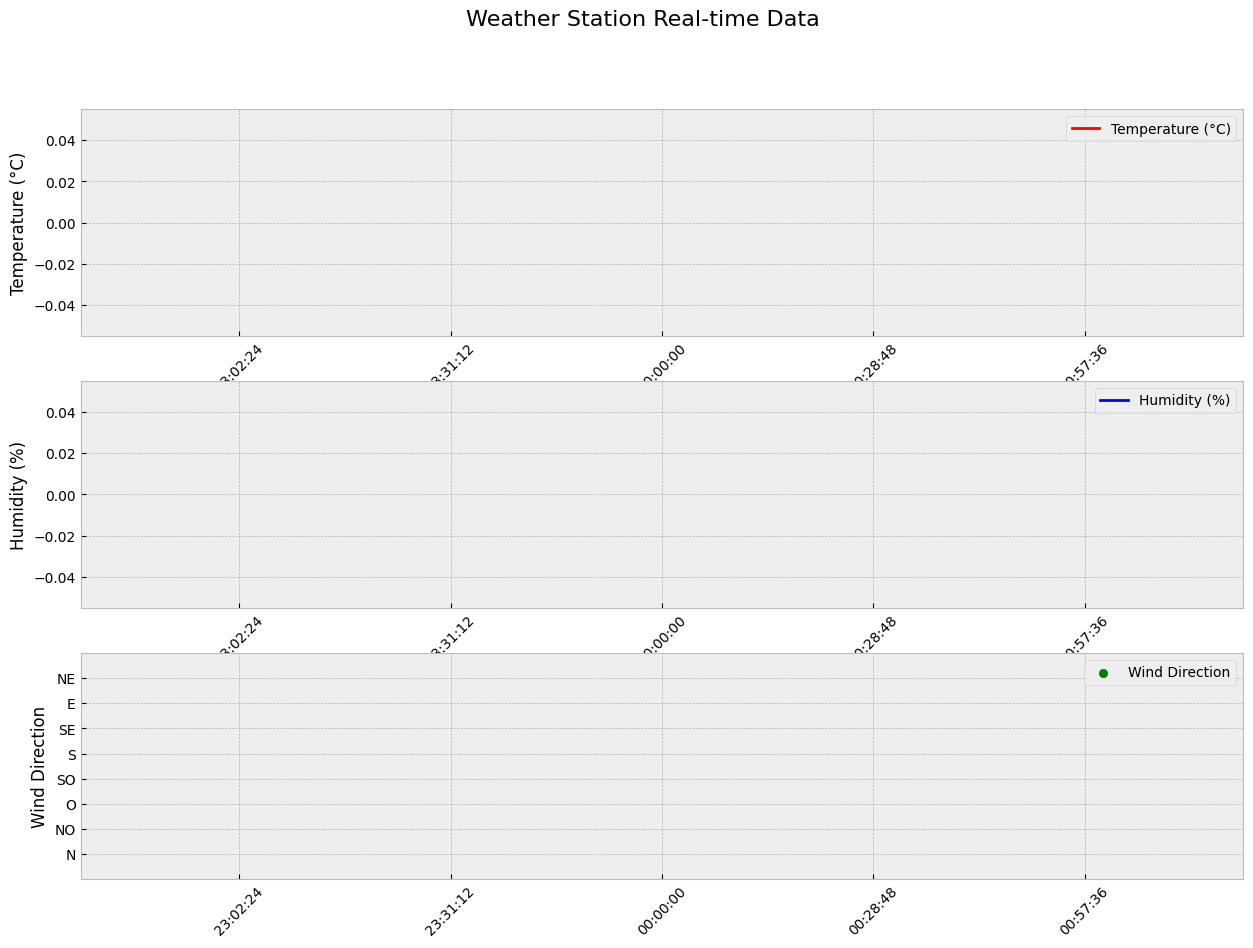

In [6]:

# Configuración del consumidor
consumer = KafkaConsumer(
    '21153',
    bootstrap_servers='164.92.76.15:9092',
    value_deserializer=lambda x: x,  # Recibimos bytes en lugar de JSON
    auto_offset_reset='earliest'     # Configurar a 'earliest' para leer mensajes antiguos
)

print("Consumer initialized and connected to Kafka broker.")

# Lista de direcciones de viento posibles
WIND_DIRECTIONS = ['N', 'NO', 'O', 'SO', 'S', 'SE', 'E', 'NE']

# Deques para almacenar las últimas 50 lecturas de cada sensor
timestamps = deque(maxlen=50)
temperatures = deque(maxlen=50)
humidities = deque(maxlen=50)
wind_directions = deque(maxlen=50)

# Configuración de la figura y los ejes
plt.style.use('bmh')
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Weather Station Real-time Data', fontsize=16)

# Configura los ejes para temperatura, humedad y dirección del viento
ax1 = plt.subplot(311)
temp_line, = ax1.plot([], [], 'r-', label='Temperature (°C)')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True)
ax1.legend()

ax2 = plt.subplot(312)
humidity_line, = ax2.plot([], [], 'b-', label='Humidity (%)')
ax2.set_ylabel('Humidity (%)')
ax2.grid(True)
ax2.legend()

ax3 = plt.subplot(313)
wind_scatter = ax3.scatter([], [], c='g', label='Wind Direction')
ax3.set_ylabel('Wind Direction')
ax3.set_ylim(-1, 8)
ax3.set_yticks(range(8))
ax3.set_yticklabels(WIND_DIRECTIONS)
ax3.grid(True)
ax3.legend()

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

print("Matplotlib figure and axes configured.")

# Decodificación de datos de 3 bytes
def decode_message(encoded_message):
    # Verifica que el mensaje tenga 3 bytes de longitud
    if len(encoded_message) != 3:
        print(f"Error: Expected 3 bytes but got {len(encoded_message)} bytes.")
        return None, None, None  # Retorna valores nulos en caso de error
    
    # Decodifica el mensaje si tiene el tamaño correcto
    packed_data = struct.unpack('>I', b'\x00' + encoded_message)[0]  # Añade un byte de 0 al inicio
    temp_int = (packed_data >> 10) & 0x3FFF
    humidity_int = (packed_data >> 3) & 0x7F
    wind_int = packed_data & 0x07

    # Convertir valores decodificados a sus formas originales
    temp = temp_int / 100.0
    humidity = humidity_int
    wind_direction = WIND_DIRECTIONS[wind_int]
    return temp, humidity, wind_direction

# Convierte las direcciones de viento a números para graficar
def wind_direction_to_number(direction):
    return WIND_DIRECTIONS.index(direction)

def update_plot(frame):
    print("Attempting to consume a message...")
    try:
        # Consumir el siguiente mensaje de Kafka
        message = next(consumer)
        print("Message consumed from Kafka.")
        
        # Decodificar el mensaje
        temp, humidity, wind = decode_message(message.value)
        if temp is None or humidity is None or wind is None:
            print("Skipping message due to decoding error.")
            return temp_line, humidity_line, wind_scatter

        # Si la decodificación es exitosa, actualizar datos de gráficos
        current_time = datetime.datetime.now()
        timestamps.append(current_time)
        temperatures.append(temp)
        humidities.append(humidity)
        wind_directions.append(wind_direction_to_number(wind))

        # Actualizar las líneas de gráficos
        temp_line.set_data(timestamps, temperatures)
        humidity_line.set_data(timestamps, humidities)

        if timestamps and wind_directions:
            wind_scatter.set_offsets(list(zip(mdates.date2num(timestamps), wind_directions)))
        
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(mdates.date2num(min(timestamps)), mdates.date2num(max(timestamps)))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        print(f"Updated plot with received data: Temp={temp}°C, Humidity={humidity}%, Wind={wind}")

    except StopIteration:
        print("No more messages to consume.")
    except Exception as e:
        print(f"Error in update_plot: {e}")

    return temp_line, humidity_line, wind_scatter

# Función principal
def main():
    print("Starting Weather Station Consumer...")
    ani = FuncAnimation(fig, update_plot, interval=1000, blit=True)
    plt.show()

if __name__ == "__main__":
    main()
